# Definition

* Problem definition, getting a somewhat unbiased estimator for binary classifier for the MNIST dataset via only one sample at training.

* First we need to make the appropriate dataset from the mnist dataset provided in the google colab as mnist_train_small.csv .

* Our goal is to at training procedure have randomized goal class that we change at each train epoch randomly may be the same, e.g 2 and label it as true(1) based on the model weights and mnist labels corresponding to it, and rest as False (0). So at each training query we will have a set that has all of these elements and we will find the similar one which is true(1) and make this discrimination by a binary-cross entropy. Here, we do require to make train and test on separate classes, which means that for teaching 0 we need true label as 0, rest false; but when we have the other x elements we have them as true labels.

Cue: Rather than predicting the class of image , we will try to predict the degree of similarity between pairs of image. This is done by representing images in N-Dimensional embedding vector which the model will generate. When these embedding vectors are represented in 2-D space , the distance between embedding of similar images will be less . Hence, the model predicts whether the images are similar or not. [https://medium.com/swlh/one-shot-learning-using-keras-8c1cd62ac382]

Cue 2: General classification models use deep convolution layers that pre-process every image to extract all the features which are then passed on through activation functions and classified using SoftMax function which generates probabilities for any given image in comparison to all the other trained classes. The class with maximum predicted probability is the one into which the image is classified into. In contrary, the proposed method takes in a single image to which any given test image is compared with to produce a similarity score in the range of 0–1 by using a sigmoid function. [https://medium.com/swlh/less-than-one-shot-learning-for-dummies-49dc2f01a679]

* Testing procedure is similar to train but without training and with the labels that we didn't use in the model.

# Preliminaries

Packages to be loaded for to do the work.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Model

In [ ]:
"""

Simple One-shot training model that is stated in the task as the meta-model 'g'
It has two linear layers and a ReLU activation function.
"""
class OneShotModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(OneShotModel, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    out = self.fc1(x)
    out = torch.relu(out)
    out = self.fc2(out)
    return out

In [ ]:
"""
deeper model with dropout.
"""
class OneShotModelv2(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.5):
        super(OneShotModelv2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = torch.relu(out)
        out = self.dropout1(out)

        out = self.fc2(out)
        out = torch.relu(out)
        out = self.dropout2(out)

        out = self.fc3(out)
        return out


# Dataset Preparation for One Sample

In [ ]:
# Here we will load the training data provided by colab
train_df = pd.read_csv("/content/sample_data/mnist_train_small.csv", header=None)
train_labels = train_df.iloc[:, 0].values
train_pixels = train_df.iloc[:, 1:].values

# Here we will load the training data provided by colab
test_df = pd.read_csv("/content/sample_data/mnist_test.csv", header=None)
test_labels = test_df.iloc[:, 0].values
test_pixels = test_df.iloc[:, 1:].values # 0,255 pixels with labels 0...9
"""
As specified on the task we check the labels for 0,1,2,3,4,5 and get them as train
and get test as 6,7,8,9 as stated.

Then use the indices to get the data.
"""

train_indices = np.isin(train_labels, [0, 1, 2, 3, 4, 5])
test_indices = np.isin(test_labels, [6, 7, 8, 9])

train_data = train_pixels[train_indices]
train_data = train_data/255.0
train_labels = train_labels[train_indices]
test_data = test_pixels[test_indices]
test_data = test_data/255.0
test_labels = test_labels[test_indices]

In [ ]:
"""
Here we define a one_sample_per_class function such that
This function will select the first occurrence of each label i.e 0,1,2,3,4 ...
Then append them as desired.

any occurence would have been selected since a digit is always
the same digit regardless we pick first one or the second one as the 1 digit.

"""

def One_sampler(data, labels):

    unique_labels = np.unique(labels)
    sample_data = []
    sample_labels = []
    for label in unique_labels:
        point = np.where(labels == label)[0][0]
        sample_data.append(data[point])
        sample_labels.append(labels[point])
    return np.array(sample_data), np.array(sample_labels)

#One sample for train labels each and for test labels each.

one_shot_train_data, one_shot_train_label = One_sampler(train_data, train_labels)
one_shot_test_data, one_shot_test_label = One_sampler(test_data, test_labels)

In [ ]:
one_shot_train_data = torch.tensor(one_shot_train_data, dtype=torch.float32)
one_shot_train_label = torch.tensor(one_shot_train_label, dtype=torch.long)
one_shot_test_data = torch.tensor(one_shot_test_data, dtype=torch.float32)
one_shot_test_label = torch.tensor(one_shot_test_label, dtype=torch.long)

In [ ]:
def sigmoid_similarity_classifier(x, weights):
    return torch.sigmoid(torch.matmul(x, weights))

# Training-Testing Step

In [ ]:
seed = 123
torch.manual_seed(seed)
input_size = one_shot_train_data.shape[1] # already flattened data so no need for flattening in the model.
output_size = input_size
hidden_size = 256
oneshotmodel = OneShotModel(input_size, hidden_size, output_size)
oneshotmodelv2 = OneShotModelv2(input_size, 512, 256, output_size, 0.5)
criterion = nn.BCELoss()
optimizer = optim.Adam(oneshotmodel.parameters(), lr=0.0001)
optimizerv2 = optim.Adam(oneshotmodelv2.parameters(), lr=0.0001)
num_epochs = 100
batch_size = 16

## Test

In [ ]:
"""
Except the evaluation mode open + the random choice of class selection
and labels etc are from the test data of 6,7,8,9 from test.csv
Rest is same as the train mode.

What we do here is basically doing the same thing as in training but has no gradient change etc.

"""
def test_model(weights,oneshotmodel = oneshotmodel,one_shot_test_label = one_shot_test_label, one_shot_test_data = one_shot_test_data, batch_size = batch_size, test_labels = test_labels, test_data = test_data):
  oneshotmodel.eval()
  accuracy_list = []
  num_iter = 1000 # number of iterations defined in the task, defined as it can be changed.

  for _ in range(num_iter):
      # Randomly sampling a test class C_i and an example X_i of the C_i
      class_val = np.random.choice(len(one_shot_test_label))
      values = one_shot_test_data[class_val].unsqueeze(0)
      test_labs = one_shot_test_label[class_val].unsqueeze(0)

      # Sample query examples (half(8) positive, half(8) negative as it is said in the task) also tried 16/16
      positive_ids = np.random.choice(np.where(test_labels == test_labs.item())[0], batch_size // 2) # 8 positive ids by the labels provided at mnist dataset
      negative_ids = np.random.choice(np.where(test_labels != test_labs.item())[0], batch_size // 2) # 8 negative ids by the labels provided by the mnist dataset
      query_data = torch.tensor(np.vstack([test_data[positive_ids], test_data[negative_ids]]), dtype=torch.float32) # 8+8 sample queries they are concatenated vertically
      query_labels = torch.tensor(np.hstack([np.ones(batch_size // 2), np.zeros(batch_size // 2)]), dtype=torch.long) # 8+8 sample query labels are concatenated vertically

      # Shuffling query data and labels
      randperm = torch.randperm(query_data.size(0))
      query_data = query_data[randperm]
      query_labels = query_labels[randperm]

      # Without gradients make the predictions and measure accuracy
      with torch.no_grad():
          predictions = sigmoid_similarity_classifier(query_data, weights)
          predicted = (predictions >= 0.5).float()
          accuracy = (predicted == query_labels).sum().item() / len(query_labels)
          accuracy_list.append(accuracy)

  average_accuracy = np.mean(accuracy_list)
  print(f'Average accuracy on one-shot MNIST test data: {average_accuracy * 100:.4f}%')
  return average_accuracy

## Train

In [ ]:
def train_model(oneshotmodel, one_shot_train_data, one_shot_train_label, train_data, train_labels, criterion, optimizer, batch_size):
    epoch_loss = 0
    oneshotmodel.train()

    # Sampling a training class C_i and an example X_i of the C_i
    class_val = np.random.choice(len(one_shot_train_label))
    values = one_shot_train_data[class_val].unsqueeze(0)
    train_labs = one_shot_train_label[class_val].unsqueeze(0)

    # Binary classifier parameters which states the true group for our system. Y_i = 1
    weights = oneshotmodel(values).squeeze()

    # Sample query examples (half positive, half negative as it is said in the task)
    positive_ids = np.random.choice(np.where(train_labels == train_labs.item())[0], batch_size // 2)
    negative_ids = np.random.choice(np.where(train_labels != train_labs.item())[0], batch_size // 2)
    query_data = torch.tensor(np.vstack([train_data[positive_ids], train_data[negative_ids]]), dtype=torch.float32)
    query_labels = torch.tensor(np.hstack([np.ones(batch_size // 2), np.zeros(batch_size // 2)]), dtype=torch.float32)

    # Shuffling query data and labels
    perm = torch.randperm(query_data.size(0))
    query_data = query_data[perm]
    query_labels = query_labels[perm]

    # Prediction and loss calculations.
    predictions = sigmoid_similarity_classifier(query_data, weights)
    loss = criterion(predictions, query_labels)

    # Backprop and minimization via Adam optimizer.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

    return epoch_loss, weights

## Run

In [ ]:
"""
try:
  oneshotmodel.load_state_dict(torch.load(best_weights_path))
  print(f"Loaded best model weights from {best_weights_path}")
  initial_hidden_size = hidden_size
except FileNotFoundError:
  print(f"No previous best model weights found at {best_weights_path}, starting from scratch.")

"""

In [ ]:
"""
Here we first initiate the oneshot model train set up,
then we select a class randomly from our one shot train labels that we created
e.g 3 then we excerpt the value as 784 which is flattened version of 28*28 matrix of a MNIST image

then we get the label also.

later we define the weights based on this class to make it Y_i = 1 which will lead others as 0.

Then as specified in the question we make the query examples by stacking them vertically with np vstack.

Here it is in ordered set version as
labels are [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0]
for that we use 1-2-3D concatenation package np hstack which stacks horizontally as name stands for that

we then convert them to torch tensors.

also randomly change their locations for not making labels like 1,1,1,1,1,1,0,0,0,0 and so rather 0,1,1,0,0,0,1,1,0 is better.

Later based on our model and the binary cross entropy loss we make our classification

with our loss function minimization.
train_labels is the priorly made train labels set-list train_labs is the labels.
*** With the classify we are actually basically doing a sigmoid based classification
since we determined a true label at the weights part which actually run the model to get those weights
and we accepted them as true, we then get our query data and look at similarities mostly based on that.

To get the similarities we make the dot product a.k.a matmul in np, then put it in sigmoid,
with that similarity relation we make the training, if it is similar but we say it is not that it results in
higher loss and for that we have original labels that we created directly from the labels mnist provides us.

then compare the result of the sigmoid either 0 or 1 with the original labels. and get the BCEloss. Also used BCEwithLogitsloss

have test_model implemented to train and added best model weights save, looks great now.

"""


patience = 10  # how many epochs to wait for improvement
best_accuracy = 0.5 # well 0.5 is for binary means nothing so thats why I made this limit.
epochs_since_improvement = 0
best_model_weights = None
best_weights_path = '/content/best_model_weights.pth'



for epoch in range(num_epochs):
    epoch_loss, weights = train_model(oneshotmodel, one_shot_train_data, one_shot_train_label, train_data, train_labels, criterion, optimizer, batch_size)
    if (((epoch + 1) % 10) == 0) or (epoch == 0):
        accuracy = test_model(weights=weights,oneshotmodel=oneshotmodel)
        print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy*100:.4f}%')

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            epochs_since_improvement = 0
            best_model_weights = oneshotmodel.state_dict().copy()
        else:
            epochs_since_improvement += 1

        if epochs_since_improvement >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break


    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Might be handy to have best weights.
if best_model_weights is not None:
    torch.save(best_model_weights, 'best_model_weights.pth')
    print("Best model weights saved.")
else:
    print("No improvement during training.")


Average accuracy on one-shot MNIST test data: 50.0687%
Epoch [1/100], Accuracy: 50.0687%
Epoch [1/100], Loss: 0.8455
Epoch [2/100], Loss: 0.5367
Epoch [3/100], Loss: 0.8453
Epoch [4/100], Loss: 0.7453
Epoch [5/100], Loss: 0.7179
Epoch [6/100], Loss: 0.5146
Epoch [7/100], Loss: 0.6940
Epoch [8/100], Loss: 0.3855
Epoch [9/100], Loss: 0.8168
Average accuracy on one-shot MNIST test data: 50.0750%
Epoch [10/100], Accuracy: 50.0750%
Epoch [10/100], Loss: 0.7113
Epoch [11/100], Loss: 0.8373
Epoch [12/100], Loss: 0.6459
Epoch [13/100], Loss: 0.7477
Epoch [14/100], Loss: 0.7110
Epoch [15/100], Loss: 0.5562
Epoch [16/100], Loss: 0.6839
Epoch [17/100], Loss: 0.7743
Epoch [18/100], Loss: 0.3250
Epoch [19/100], Loss: 0.6653
Average accuracy on one-shot MNIST test data: 50.4062%
Epoch [20/100], Accuracy: 50.4062%
Epoch [20/100], Loss: 0.6719
Epoch [21/100], Loss: 0.6797
Epoch [22/100], Loss: 0.6093
Epoch [23/100], Loss: 0.6527
Epoch [24/100], Loss: 0.6287
Epoch [25/100], Loss: 0.6455
Epoch [26/100],

In [ ]:
for epoch in range(num_epochs):
    epoch_loss, weights = train_model(oneshotmodelv2, one_shot_train_data, one_shot_train_label, train_data, train_labels, criterion, optimizerv2, batch_size)
    if (((epoch + 1) % 10) == 0) or (epoch == 0):
        accuracy = test_model(weights=weights,oneshotmodel=oneshotmodelv2)
        print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy*100:.4f}%')

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            epochs_since_improvement = 0
            best_model_weights = oneshotmodel.state_dict().copy()
        else:
            epochs_since_improvement += 1

        if epochs_since_improvement >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break


    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Might be handy to have best weights.
if best_model_weights is not None:
    torch.save(best_model_weights, 'best_model_weights.pth')
    print("Best model weights saved.")
else:
    print("No improvement during training.")

Average accuracy on one-shot MNIST test data: 50.0469%
Epoch [1/100], Accuracy: 50.0469%
Epoch [1/100], Loss: 0.5787
Epoch [2/100], Loss: 0.4662
Epoch [3/100], Loss: 0.4697
Epoch [4/100], Loss: 0.5250
Epoch [5/100], Loss: 0.5528
Epoch [6/100], Loss: 0.6959
Epoch [7/100], Loss: 0.4413
Epoch [8/100], Loss: 0.6419
Epoch [9/100], Loss: 0.5619
Average accuracy on one-shot MNIST test data: 49.6156%
Epoch [10/100], Accuracy: 49.6156%
Epoch [10/100], Loss: 0.5454
Epoch [11/100], Loss: 0.5755
Epoch [12/100], Loss: 0.5697
Epoch [13/100], Loss: 0.5803
Epoch [14/100], Loss: 0.6622
Epoch [15/100], Loss: 0.5860
Epoch [16/100], Loss: 0.5465
Epoch [17/100], Loss: 0.5055
Epoch [18/100], Loss: 0.6330
Epoch [19/100], Loss: 0.3749
Average accuracy on one-shot MNIST test data: 49.5344%
Epoch [20/100], Accuracy: 49.5344%
Epoch [20/100], Loss: 0.5870
Epoch [21/100], Loss: 0.3615
Epoch [22/100], Loss: 0.5945
Epoch [23/100], Loss: 0.4557
Epoch [24/100], Loss: 0.3755
Epoch [25/100], Loss: 0.6072
Epoch [26/100],

# Initial Observation Result

* Only changing the learning rate slightly to lower from 0.001 made a change but a slight change, tried 0.01,0.001,0.0001,0.00001 ... smaller ones didn't contribue since it made the gradient* learning rate eta so small. As W_new = W_old - eta*gradL so the search was relatively slow at that point.

* Epoch number helps to saturate at 0.5 which is not nice since it means we are not making the system learn a generalized pattern that can understand each number, rather it becomes 50/50 coin toss at this point so cannot classify whether it is the label that we asked for or not (since we made one of the labels as Y_i =1 I call this the label we asked, can say the searched label or so.)

* Number of hidden state or neurons also doesn't change a thing even at higher neurons it wont overfit or make worse accuracy, since we used the same seed for all experiments, can say that epoch doesn't change making more complex model does not change (tried), more hidden states don't change. Also changing batch size which will change query size also didn't change.



# Final Results

* After changing the structure where I had 2 loops in the train rather than 1, which is more appropriate to what task asked for, but still the accuracy fluctuates around 50 percent

* It is seen in the papers that most one-shot vision tasks use cnn based similarity measuring networks such as triplet network or siamese network where they use constrastive loss for two identical models at siamese, here we didn't do such thing, but it was great to see learn about them.

* Decreasing learning rate or increasing it does not make a significant change at accuracy. Only changes the loss, but does not contribute to the better predictions.

* Similar patterns at changing hidden_size and the batch_size, they seem to not change the randomness of the accuracy scores and giving similar from 49 to 51 percent accuracy scores at whole run. Yet changes the learning.

* At the end we couldn't determine an unbiased estimator with 2 layer mlp to MNIST problem.

* As a result since loss changes --> decreases we can say that model learns at the epochs but model does not learn valuable information to have better accuracy. Hence in statistics we can say we couldn't find an unbiased estimator with 2 layer MLP network.

* Another deeper model with dropout experimented, accuracy still did not improve, learning is perhaps faster but not giving any useful information for the task.



# Visualization of the samples

* Check the Prepared dataset for images that are created.

## 0

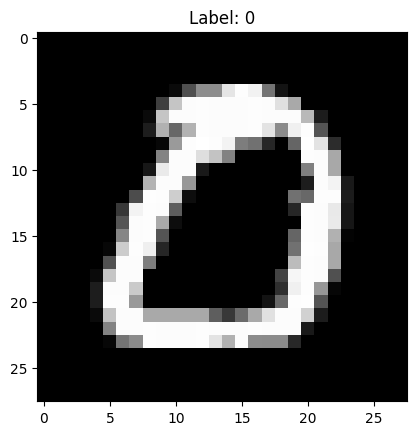

In [ ]:
image_index = 0
image = one_shot_train_data[image_index]

# Reshape the image to 28x28 pixels due 784 is 28**2
image = image.reshape(28, 28)

# Imagery
plt.imshow(image, cmap='gray')
plt.title(f"Label: {one_shot_train_label[image_index]}")
plt.show()

## 1

Most disgusting 1, I have ever saw but this does not concern the CNN, and I plan on using CNN then there is nothing much to worry about.

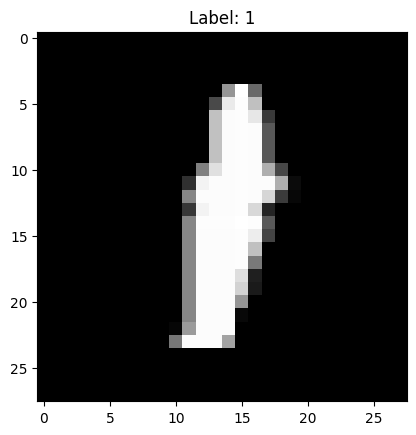

In [ ]:
image_index = 1
image = one_shot_train_data[image_index]

# Reshape the image to 28x28 pixels due 784 is 28**2
image = image.reshape(28, 28)

# Imagery
plt.imshow(image, cmap='gray')
plt.title(f"Label: {one_shot_train_label[image_index]}")
plt.show()

## 2

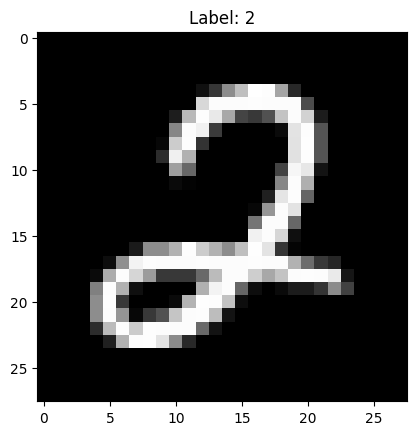

In [ ]:
image_index = 2
image = one_shot_train_data[image_index]

# Reshape the image to 28x28 pixels due 784 is 28**2
image = image.reshape(28, 28)

# Imagery
plt.imshow(image, cmap='gray')
plt.title(f"Label: {one_shot_train_label[image_index]}")
plt.show()

## 3

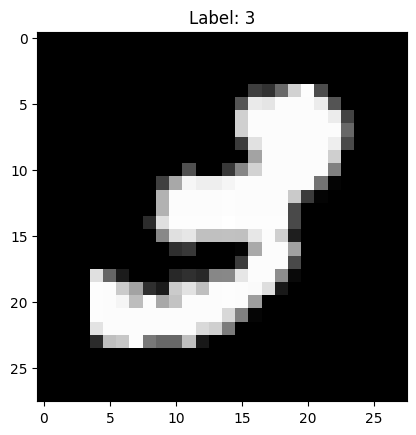

In [ ]:
image_index = 3
image = one_shot_train_data[image_index]

# Reshape the image to 28x28 pixels due 784 is 28**2
image = image.reshape(28, 28)

# Imagery
plt.imshow(image, cmap='gray')
plt.title(f"Label: {one_shot_train_label[image_index]}")
plt.show()

## 4

I wouldnt consider this a 4 but okay. (Doesnt look like any other digit either.)

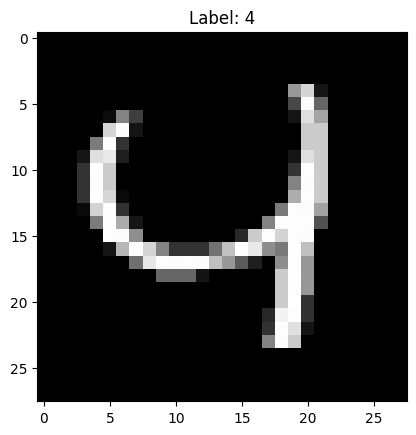

In [ ]:
image_index = 4
image = one_shot_train_data[image_index]

# Reshape the image to 28x28 pixels due 784 is 28**2
image = image.reshape(28, 28)

# Imagery
plt.imshow(image, cmap='gray')
plt.title(f"Label: {one_shot_train_label[image_index]}")
plt.show()

## 5

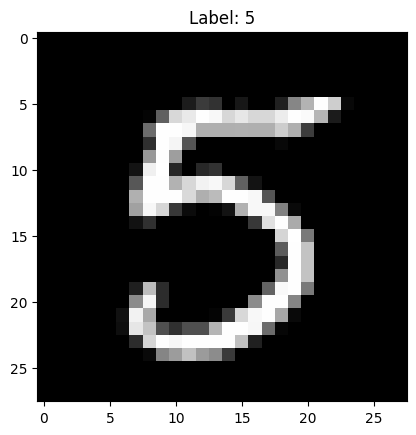

In [ ]:
image_index = 5
image = one_shot_train_data[image_index]

# Reshape the image to 28x28 pixels due 784 is 28**2
image = image.reshape(28, 28)

# Imagery
plt.imshow(image, cmap='gray')
plt.title(f"Label: {one_shot_train_label[image_index]}")
plt.show()

# References

* https://paperswithcode.com/paper/siamese-neural-networks-for-one-shot-image

* https://paperswithcode.com/sota/one-shot-learning-on-mnist

* https://www.kaggle.com/datasets/chats351/oneshot-learning

* https://github.com/rarriaza/MNIST_One_Shot_Learning/tree/main

* https://github.com/fangpin/siamese-pytorch

For inspiration

* https://medium.com/hackernoon/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e

* https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7